In [1]:
import xarray as xr
from glob import glob
import pandas as pd
from tqdm.auto import tqdm
from tqdm.contrib.concurrent import thread_map
import os
from pprint import pprint
import matplotlib.pyplot as plt
wave_wind_mapping = {
    # Combined Wave Parameters
    "Hsig": "HTSGW",       # Hsig: Significant wave height -> HTSGW: Significant Height of Combined Wind Waves and Swell
    "Dir": "DIRPW",      # PkDir: Peak wave direction -> DIRPW: Direction of Combined Wind Waves and Swell (Often peak direction is reported as the primary direction)
    "Tm01": "PERPW",       # Tm01: Mean wave period (m01) -> PERPW: Mean Period of Combined Wind Waves and Swell (Tm01 is a common representation for mean period)
    # Wind Parameters
    #"Windv_x": "UGRD",     # Windv_x: Horizontal component of wind velocity -> UGRD: U-component of wind
    #"Windv_y": "VGRD",     # Windv_y: Vertical component of wind velocity (Likely intended as the other horizontal component) -> VGRD: V-component of wind
}
GEFS = xr.open_dataset("NZ_GEFS/NZ_GEFS.nc")
GEFS

<xarray.Dataset> Size: 3GB
Dimensions:    (latitude: 61, longitude: 60, time: 58384)
Coordinates:
  * latitude   (latitude) float64 488B -33.0 -33.25 -33.5 ... -47.5 -47.75 -48.0
  * longitude  (longitude) float64 480B 165.0 165.3 165.5 ... 179.3 179.5 179.8
  * time       (time) datetime64[ns] 467kB 2000-01-08T03:00:00 ... 2020-01-01
Data variables:
    swh        (time, latitude, longitude) float32 855MB ...
    dirpw      (time, latitude, longitude) float32 855MB ...
    perpw      (time, latitude, longitude) float32 855MB ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   gefs_wave_reforecast
    product:                 GEFSv12/wave_reforecast
    description:             NOAA Wave Ensemble Reforecast
    remote_grib:             https://noaa-nws-gefswaves-reforecast-pds.s3.ama...
    local_grib:              GEFS/gefs_wave_reforecast/20000108/subset_b4ef68...
    search:                  :(?:HTSGW|DIRPW|PERPW):surface:(?:anl|(?:3|6|9|1...

In [3]:
GEFS_mean = GEFS.mean()
GEFS_std = GEFS.std()
GEFS_mean, GEFS_std

(<xarray.Dataset> Size: 12B
 Dimensions:  ()
 Data variables:
     swh      float32 4B 2.704
     dirpw    float32 4B 206.7
     perpw    float32 4B 12.03,
 <xarray.Dataset> Size: 12B
 Dimensions:  ()
 Data variables:
     swh      float32 4B 1.205
     dirpw    float32 4B 71.29
     perpw    float32 4B 2.892)

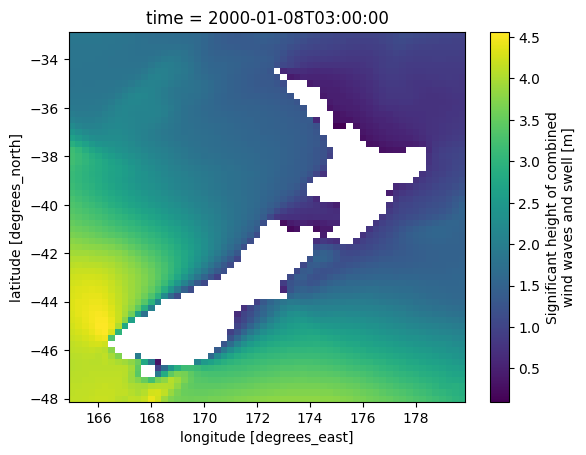

In [4]:
GEFS.swh[0].plot()

In [5]:
NI = xr.open_dataset("Joao/NI.nc")
display(NI)
NI_mean = NI.mean()
NI_std = NI.std()
NI_mean, NI_std

<xarray.Dataset> Size: 14GB
Dimensions:    (time: 58383, latitude: 103, longitude: 100)
Coordinates:
  * time       (time) datetime64[ns] 467kB 2000-01-08T03:00:00 ... 2019-12-31...
  * latitude   (latitude) float32 412B -42.99 -42.9 -42.81 ... -33.56 -33.46
  * longitude  (longitude) float32 400B 170.4 170.5 170.6 ... 179.4 179.5 179.6
Data variables:
    Dir        (time, latitude, longitude) float64 5GB ...
    Hsig       (time, latitude, longitude) float64 5GB ...
    RTm01      (time, latitude, longitude) float64 5GB ...

(<xarray.Dataset> Size: 24B
 Dimensions:  ()
 Data variables:
     Dir      float64 8B 192.2
     Hsig     float64 8B 2.354
     RTm01    float64 8B 7.524,
 <xarray.Dataset> Size: 24B
 Dimensions:  ()
 Data variables:
     Dir      float64 8B 86.61
     Hsig     float64 8B 1.118
     RTm01    float64 8B 1.861)

In [19]:
GEFS_NI = GEFS.sel(
    latitude=slice(NI.latitude.max().to_dict()["data"], NI.latitude.min().to_dict()["data"]),
    longitude=slice(NI.longitude.min().to_dict()["data"], NI.longitude.max().to_dict()["data"]),
    time=(GEFS.time < pd.Timestamp("2020-01-01"))
)
display(GEFS_NI)
NI_GEFS_mean = GEFS_NI.mean()
NI_GEFS_std = GEFS_NI.std()
display(NI_GEFS_mean, NI_GEFS_std)
GEFS_NI.to_netcdf("NZ_GEFS/GEFS_NI.nc")

<xarray.Dataset> Size: 986MB
Dimensions:    (latitude: 38, longitude: 37, time: 58383)
Coordinates:
  * latitude   (latitude) float64 304B -33.5 -33.75 -34.0 ... -42.5 -42.75
  * longitude  (longitude) float64 296B 170.5 170.8 171.0 ... 179.0 179.3 179.5
  * time       (time) datetime64[ns] 467kB 2000-01-08T03:00:00 ... 2019-12-31...
Data variables:
    swh        (time, latitude, longitude) float32 328MB 1.45 1.42 ... 2.09 2.12
    dirpw      (time, latitude, longitude) float32 328MB 224.6 224.6 ... 210.2
    perpw      (time, latitude, longitude) float32 328MB 11.66 11.67 ... 9.76
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   gefs_wave_reforecast
    product:                 GEFSv12/wave_reforecast
    description:             NOAA Wave Ensemble Reforecast
    remote_grib:             https://noaa-nws-gefswaves-reforecast-pds.s3.ama...
    local_grib:              GEFS/gefs_wave_reforecast/20000108/subset_b4ef68...
    search:                  :(?:HTSGW|DIRPW|PERPW):surface:(?:anl|(?:3|6|9|1...

<xarray.Dataset> Size: 12B
Dimensions:  ()
Data variables:
    swh      float32 4B 2.27
    dirpw    float32 4B 193.0
    perpw    float32 4B 11.2

<xarray.Dataset> Size: 12B
Dimensions:  ()
Data variables:
    swh      float32 4B 1.067
    dirpw    float32 4B 85.64
    perpw    float32 4B 3.167

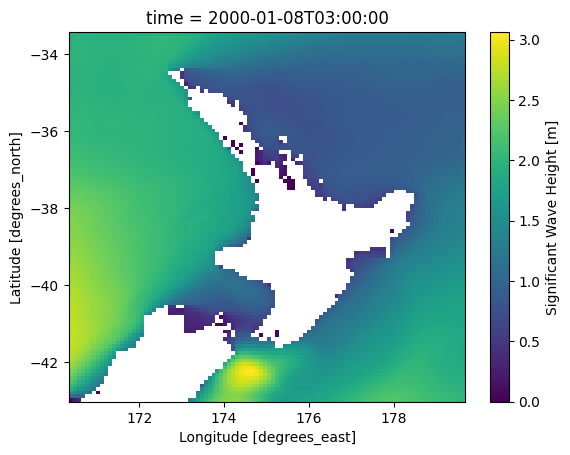

In [20]:
NI.Hsig[0].plot()

In [24]:
assert GEFS_NI.time[0] == NI.time[0]

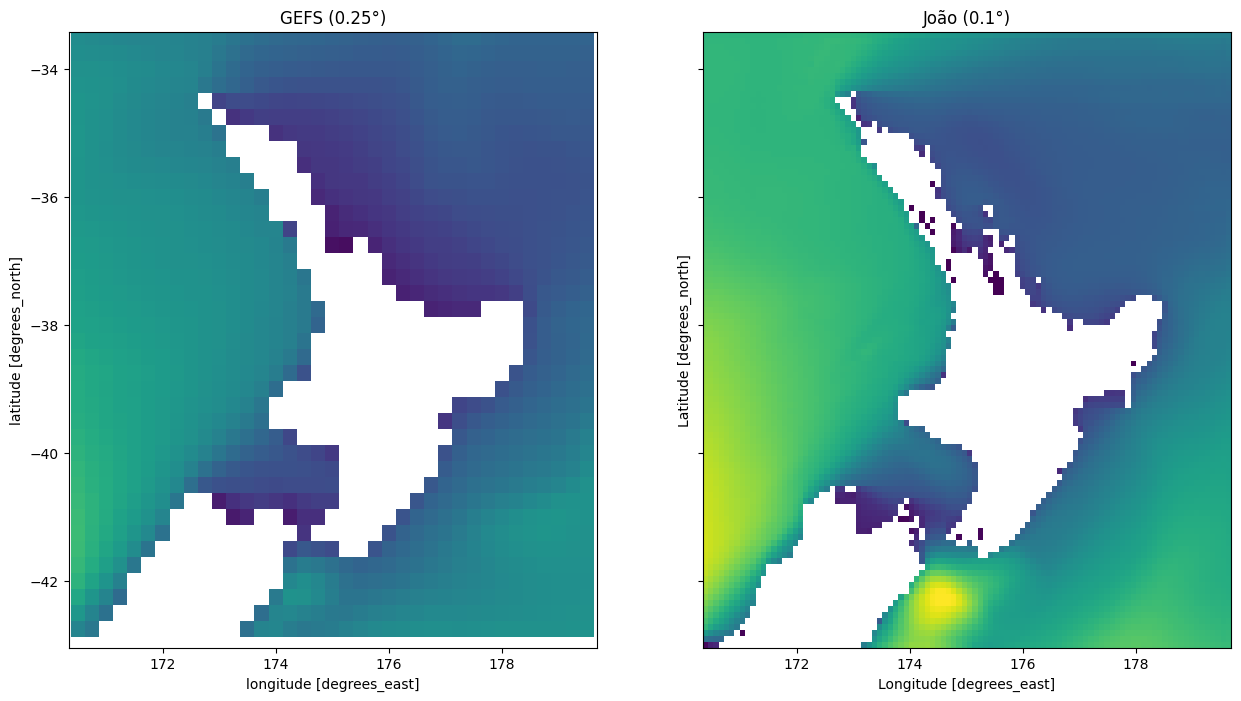

In [25]:
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(15, 8), sharex=True, sharey=True)
GEFS_NI.swh[0].plot(ax=ax1, vmin=0, vmax=3,add_colorbar=False)
#SI.sel(time="2000-01-08 03:00:00").Hsig.plot(ax=ax2, vmin=0, vmax=3)
NI.Hsig[0].plot(ax=ax2, vmin=0, vmax=3, add_colorbar=False)
ax1.title.set_text("GEFS (0.25°)")
ax2.title.set_text("João (0.1°)")

In [26]:
SI = xr.open_dataset("Joao/SI.nc")
display(SI)
SI_mean = SI.mean()
SI_std = SI.std()
SI_mean, SI_std

<xarray.Dataset> Size: 17GB
Dimensions:    (time: 58383, latitude: 103, longitude: 121)
Coordinates:
  * time       (time) datetime64[ns] 467kB 2000-01-08T03:00:00 ... 2019-12-31...
  * latitude   (latitude) float32 412B -48.04 -47.94 -47.85 ... -38.6 -38.51
  * longitude  (longitude) float32 484B 165.6 165.7 165.8 ... 176.6 176.7 176.8
Data variables:
    Dir        (time, latitude, longitude) float64 6GB ...
    Hsig       (time, latitude, longitude) float64 6GB ...
    RTm01      (time, latitude, longitude) float64 6GB ...

(<xarray.Dataset> Size: 24B
 Dimensions:  ()
 Data variables:
     Dir      float64 8B 220.3
     Hsig     float64 8B 2.965
     RTm01    float64 8B 8.531,
 <xarray.Dataset> Size: 24B
 Dimensions:  ()
 Data variables:
     Dir      float64 8B 70.26
     Hsig     float64 8B 1.289
     RTm01    float64 8B 1.765)

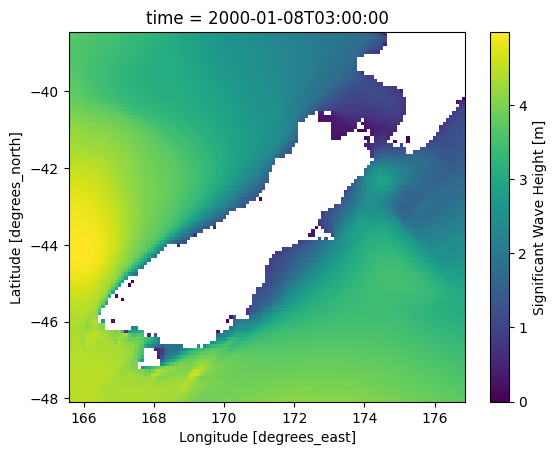

In [27]:
SI.Hsig[0].plot()

In [28]:
GEFS_SI = GEFS.sel(
    latitude=slice(SI.latitude.max().to_dict()["data"], SI.latitude.min().to_dict()["data"]),
    longitude=slice(SI.longitude.min().to_dict()["data"], SI.longitude.max().to_dict()["data"]),
    time=(GEFS.time < pd.Timestamp("2020-01-01"))
)
display(GEFS_SI)
SI_GEFS_mean = GEFS_SI.mean()
SI_GEFS_std = GEFS_SI.std()
display(SI_GEFS_mean, SI_GEFS_std)
GEFS_SI.to_netcdf("NZ_GEFS/GEFS_SI.nc")

<xarray.Dataset> Size: 1GB
Dimensions:    (latitude: 38, longitude: 45, time: 58383)
Coordinates:
  * latitude   (latitude) float64 304B -38.75 -39.0 -39.25 ... -47.75 -48.0
  * longitude  (longitude) float64 360B 165.8 166.0 166.3 ... 176.3 176.5 176.8
  * time       (time) datetime64[ns] 467kB 2000-01-08T03:00:00 ... 2019-12-31...
Data variables:
    swh        (time, latitude, longitude) float32 399MB 2.89 2.82 ... 2.03 2.03
    dirpw      (time, latitude, longitude) float32 399MB 215.9 215.9 ... 246.9
    perpw      (time, latitude, longitude) float32 399MB 16.03 16.01 ... 16.35
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   gefs_wave_reforecast
    product:                 GEFSv12/wave_reforecast
    description:             NOAA Wave Ensemble Reforecast
    remote_grib:             https://noaa-nws-gefswaves-reforecast-pds.s3.ama...
    local_grib:              GEFS/gefs_wave_reforecast/20000108/subset_b4ef68...
    search:                  :(?:HTSGW|DIRPW|PERPW):surface:(?:anl|(?:3|6|9|1...

<xarray.Dataset> Size: 12B
Dimensions:  ()
Data variables:
    swh      float32 4B 2.825
    dirpw    float32 4B 216.8
    perpw    float32 4B 12.26

<xarray.Dataset> Size: 12B
Dimensions:  ()
Data variables:
    swh      float32 4B 1.265
    dirpw    float32 4B 61.43
    perpw    float32 4B 2.732

In [29]:
stats = {
    "input": {
        "NI": {
            "swh": {"mean": NI_GEFS_mean.to_dict()["data_vars"]["swh"]["data"], "std": NI_GEFS_std.to_dict()["data_vars"]["swh"]["data"]},
            "dirpw": {"mean": NI_GEFS_mean.to_dict()["data_vars"]["dirpw"]["data"], "std": NI_GEFS_std.to_dict()["data_vars"]["dirpw"]["data"]},
            "perpw": {"mean": NI_GEFS_mean.to_dict()["data_vars"]["perpw"]["data"], "std": NI_GEFS_std.to_dict()["data_vars"]["perpw"]["data"]},
        },
        "SI": {
            "swh": {"mean": SI_GEFS_mean.to_dict()["data_vars"]["swh"]["data"], "std": SI_GEFS_std.to_dict()["data_vars"]["swh"]["data"]},
            "dirpw": {"mean": SI_GEFS_mean.to_dict()["data_vars"]["dirpw"]["data"], "std": SI_GEFS_std.to_dict()["data_vars"]["dirpw"]["data"]},
            "perpw": {"mean": SI_GEFS_mean.to_dict()["data_vars"]["perpw"]["data"], "std": SI_GEFS_std.to_dict()["data_vars"]["perpw"]["data"]},
        },
    },
    "output": {
        "NI": {
            "Hsig": {"mean": NI_mean.to_dict()["data_vars"]["Hsig"]["data"], "std": NI_std.to_dict()["data_vars"]["Hsig"]["data"]},
            "Dir": {"mean": NI_mean.to_dict()["data_vars"]["Dir"]["data"], "std": NI_std.to_dict()["data_vars"]["Dir"]["data"]},
            "RTm01": {"mean": NI_mean.to_dict()["data_vars"]["RTm01"]["data"], "std": NI_std.to_dict()["data_vars"]["RTm01"]["data"]},
        },
        "SI": {
            "Hsig": {"mean": SI_mean.to_dict()["data_vars"]["Hsig"]["data"], "std": SI_std.to_dict()["data_vars"]["Hsig"]["data"]},
            "Dir": {"mean": SI_mean.to_dict()["data_vars"]["Dir"]["data"], "std": SI_std.to_dict()["data_vars"]["Dir"]["data"]},
            "RTm01": {"mean": SI_mean.to_dict()["data_vars"]["RTm01"]["data"], "std": SI_std.to_dict()["data_vars"]["RTm01"]["data"]},
        },
    }
}
pprint(stats)

{'input': {'NI': {'dirpw': {'mean': 192.9602508544922,
                            'std': 85.63998413085938},
                  'perpw': {'mean': 11.202037811279297,
                            'std': 3.167376756668091},
                  'swh': {'mean': 2.2699050903320312,
                          'std': 1.0673556327819824}},
           'SI': {'dirpw': {'mean': 216.8441619873047, 'std': 61.4292106628418},
                  'perpw': {'mean': 12.260129928588867,
                            'std': 2.7322304248809814},
                  'swh': {'mean': 2.8249287605285645,
                          'std': 1.2646342515945435}}},
 'output': {'NI': {'Dir': {'mean': 192.24431508996267,
                           'std': 86.60533038130899},
                   'Hsig': {'mean': 2.354201828600661,
                            'std': 1.1177195941901203},
                   'RTm01': {'mean': 7.523696820384308,
                             'std': 1.860881998333353}},
            'SI': {'Dir': {'mean':